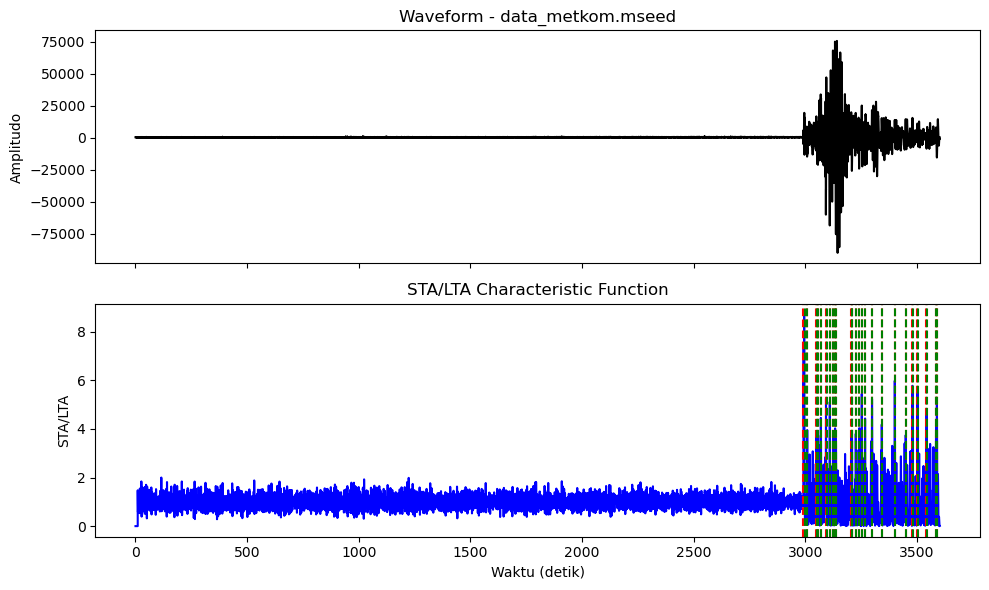

In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
from obspy import read
from obspy.signal.trigger import classic_sta_lta, trigger_onset
import matplotlib.pyplot as plt
import os


class STA_LTA_App:
    def __init__(self, root):
        self.root = root
        self.root.title("Deteksi Gempa Metode STA/LTA (OOP GUI)")
        self.root.geometry("500x400")
        self.root.resizable(False, False)

        self.file_path = None
        self.stream = None
        self.sta = tk.DoubleVar(value=1.0)
        self.lta = tk.DoubleVar(value=10.0)
        self.on_thres = tk.DoubleVar(value=3.5)
        self.off_thres = tk.DoubleVar(value=1.0)

        self.create_widgets()

    def create_widgets(self):
        tk.Label(self.root, text="Pengaturan STA/LTA", font=("Arial", 14, "bold")).pack(pady=10)

        # Input parameter
        frame = tk.Frame(self.root)
        frame.pack(pady=5)
        tk.Label(frame, text="STA (detik): ").grid(row=0, column=0, sticky="e")
        tk.Entry(frame, textvariable=self.sta, width=8).grid(row=0, column=1, padx=5)
        tk.Label(frame, text="LTA (detik): ").grid(row=1, column=0, sticky="e")
        tk.Entry(frame, textvariable=self.lta, width=8).grid(row=1, column=1, padx=5)
        tk.Label(frame, text="On Threshold: ").grid(row=2, column=0, sticky="e")
        tk.Entry(frame, textvariable=self.on_thres, width=8).grid(row=2, column=1, padx=5)
        tk.Label(frame, text="Off Threshold: ").grid(row=3, column=0, sticky="e")
        tk.Entry(frame, textvariable=self.off_thres, width=8).grid(row=3, column=1, padx=5)

        # Tombol-tombol
        tk.Button(self.root, text="📂 Buka File Seismogram", command=self.load_file, bg="#3498db", fg="white", width=25).pack(pady=10)
        tk.Button(self.root, text="▶️ Jalankan STA/LTA", command=self.run_sta_lta, bg="#2ecc71", fg="white", width=25).pack(pady=5)
        tk.Button(self.root, text="💾 Simpan Hasil (PNG)", command=self.save_results, bg="#e67e22", fg="white", width=25).pack(pady=5)
        tk.Button(self.root, text="❌ Keluar", command=self.root.quit, bg="#e74c3c", fg="white", width=25).pack(pady=10)

    def load_file(self):
        path = filedialog.askopenfilename(title="Pilih File Seismogram", filetypes=[("MiniSEED", "*.mseed"), ("Semua file", "*.*")])
        if path:
            try:
                self.stream = read(path)
                self.file_path = path
                messagebox.showinfo("Berhasil", f"File {os.path.basename(path)} berhasil dimuat.")
            except Exception as e:
                messagebox.showerror("Error", f"Gagal membaca file:\n{e}")

    def run_sta_lta(self):
        if not self.stream:
            messagebox.showwarning("Peringatan", "Silakan muat file seismogram terlebih dahulu.")
            return

        tr = self.stream[0]
        df = tr.stats.sampling_rate

        cft = classic_sta_lta(tr.data, int(self.sta.get() * df), int(self.lta.get() * df))
        on_off = trigger_onset(cft, self.on_thres.get(), self.off_thres.get())

        # Plot hasil
        fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        ax[0].plot(tr.times(), tr.data, "k")
        ax[0].set_title(f"Waveform - {os.path.basename(self.file_path)}")
        ax[0].set_ylabel("Amplitudo")

        ax[1].plot(tr.times(), cft, "b")
        for x in on_off:
            ax[1].axvline(tr.times()[x[0]], color="r", linestyle="--")
            ax[1].axvline(tr.times()[x[1]], color="g", linestyle="--")
        ax[1].set_title("STA/LTA Characteristic Function")
        ax[1].set_xlabel("Waktu (detik)")
        ax[1].set_ylabel("STA/LTA")

        plt.tight_layout()
        plt.show()

        self.cft = cft
        self.tr = tr
        self.on_off = on_off

    def save_results(self):
        if not hasattr(self, "cft"):
            messagebox.showwarning("Peringatan", "Belum ada hasil untuk disimpan. Jalankan STA/LTA dulu.")
            return

        save_path = filedialog.asksaveasfilename(defaultextension=".png", filetypes=[("PNG Files", "*.png")])
        if save_path:
            tr = self.tr
            cft = self.cft
            on_off = self.on_off

            fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
            ax[0].plot(tr.times(), tr.data, "k")
            ax[1].plot(tr.times(), cft, "b")
            for x in on_off:
                ax[1].axvline(tr.times()[x[0]], color="r", linestyle="--")
                ax[1].axvline(tr.times()[x[1]], color="g", linestyle="--")

            plt.tight_layout()
            plt.savefig(save_path)
            plt.close(fig)
            messagebox.showinfo("Berhasil", f"Hasil disimpan di:\n{save_path}")


if __name__ == "__main__":
    root = tk.Tk()
    app = STA_LTA_App(root)
    root.mainloop()
